In [1]:
%load_ext watermark
import warnings
warnings.filterwarnings("ignore") 
from IPython.core.display import display, HTML

import time

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import scipy.stats as scs
from scipy.stats import multivariate_normal as mvn
import sklearn.mixture as mix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%watermark



2017-08-13T00:37:41-05:00

CPython 3.5.2
IPython 5.2.2

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-81-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [1]:
#Dataset: Class heights with groupds sep by gender
# import class heights
f = 'https://raw.githubusercontent.com/BlackArbsCEO/Mixture_Models/K-Means%2C-E-M%2C-Mixture-Models/Class_heights.csv'

data = pd.read_csv(f)
#data.info()

height = data['Height (in)']
data.head()

NameError: name 'pd' is not defined

In [3]:
#We use the Gaussian Distributions


In [4]:
# Expectation step:
# Code sourced from:
#    http://people.duke.edu/~ccc14/sta-663/EMAlgorithm.html

def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape #20, 2
    k = len(pis) #priors count ie 2 here

    ll_old = 0
    for i in range(max_iter):
        print('\nIteration: ', i)
        print()
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0) #always sum(0) here in the pdf dist is equals 1
        print("wis")
        print(ws)

        # M-step
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n
        print("pis")
        print(pis)
        
        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()
        print("mus")
        print(mus)
        
        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()
        print("sigmas")
        print(sigmas)
        
        new_mus = (np.diag(mus)[0], np.diag(mus)[1])
        new_sigs = (np.unique(np.diag(sigmas[0]))[0], np.unique(np.diag(sigmas[1]))[0])
        df = (pd.DataFrame(index=[1, 2]).assign(mus = new_mus).assign(sigs = new_sigs))
        
        xx = np.linspace(0, 100, 100)
        yy = scs.multivariate_normal.pdf(xx, mean=new_mus[0], cov=new_sigs[0])
        
        colors = sns.color_palette('Dark2', 3)
        fig, ax = plt.subplots(figsize=(9, 7))
        ax.set_ylim(-0.001, np.max(yy))
        ax.plot(xx, yy, color=colors[1])
        ax.axvline(new_mus[0], ymin=0., color=colors[1])
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[1])
        lo, hi = ax.get_ylim()
        ax.annotate('$\mu_1$:' + str(new_mus[0]), 
                    fontsize=12, fontweight='demi',
                    xy=(new_mus[0], (hi-lo) / 2), 
                    xycoords='data', xytext=(80, (hi-lo) / 2),
                    arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[2])
        
        yy2 = scs.multivariate_normal.pdf(xx, mean=new_mus[1], cov=new_sigs[1])
        
        ax.plot(xx, yy2, color=colors[2])
        ax.axvline(new_mus[1], ymin=0., color=colors[2])
        lo, hi = ax.get_ylim()
        ax.annotate('$\mu_2$:' + str(new_mus[1]), 
                    fontsize=12, fontweight='demi',
            xy=(new_mus[1], (hi-lo) / 2), xycoords='data', xytext=(25, (hi-lo) / 2),
            arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy2, alpha=0.5, color=colors[2])
        
        dot_kwds = dict(markerfacecolor='white', markeredgecolor='black', markeredgewidth=1, markersize=10)
        ax.plot(height, len(height)*[0], 'o', **dot_kwds)
        ax.set_ylim(-0.001, np.max(yy2))
        
        
        print(df.T)   
        
        # update complete log likelihoood
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)
        print('log_likelihood:' + str(ll_new))
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
        
    return ll_new, pis, mus, sigmas


Iteration:  0

wis
[[ 0.15034227  0.13414744  0.13034968  0.14614289  0.1409376   0.157595
   0.14738533  0.10759068  0.153434    0.17759673  0.94379188  0.94656847
   0.94270378  0.94419169  0.94069302  0.94581855  0.94186795  0.94170383
   0.92649554  0.94162457]
 [ 0.84965773  0.86585256  0.86965032  0.85385711  0.8590624   0.842405
   0.85261467  0.89240932  0.846566    0.82240327  0.05620812  0.05343153
   0.05729622  0.05580831  0.05930698  0.05418145  0.05813205  0.05829617
   0.07350446  0.05837543]]
pis
[ 0.54304904  0.45695096]
mus
[[ 61.36292784   8.60973497]
 [  5.41495021  59.65968496]]
sigmas
[[[ 557.85090604 -504.55550666]
  [-504.55550666  469.24075043]]

 [[ 295.95556361 -266.41481791]
  [-266.41481791  244.38235249]]]
               1           2
mus    61.362928   59.659685
sigs  469.240750  244.382352
log_likelihood:-141.809168765

Iteration:  1

wis
[[  2.23663268e-02   1.77062282e-02   2.91451733e-02   2.19995618e-02
    2.02745276e-02   2.89433336e-02   2.730221

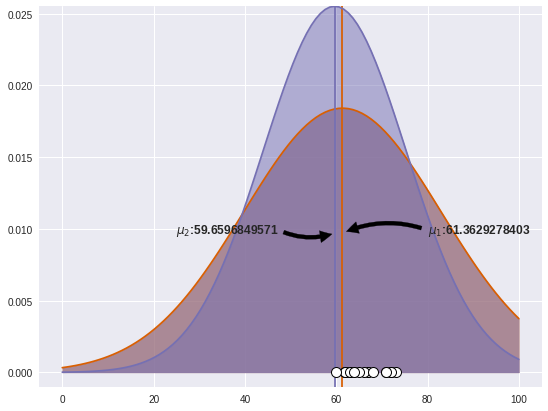

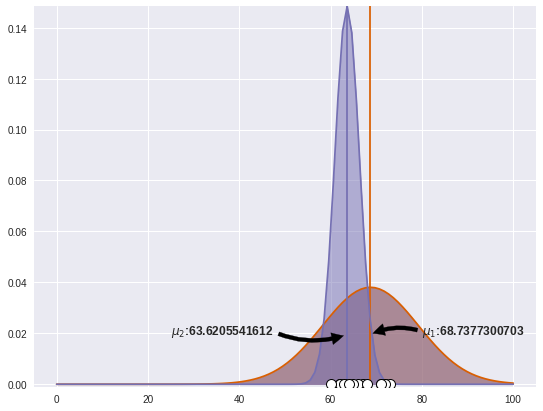

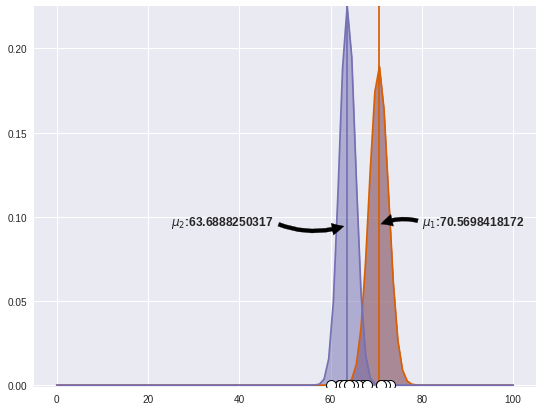

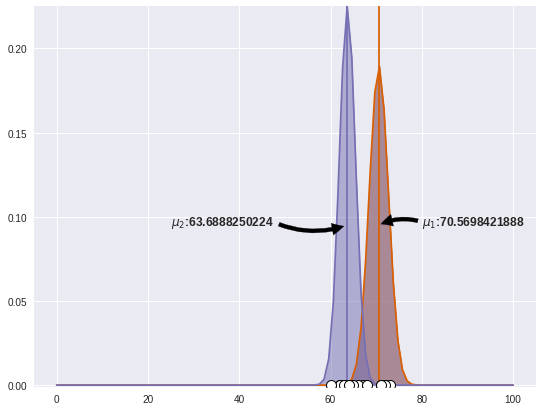

In [5]:
n = len(height)

# Ground truthish
_mus = np.array([[0, data.groupby('Gender').mean().iat[0, 0]], 
                 [data.groupby('Gender').mean().iat[1, 0], 0]])#this groupby M and F and finds the mean
_sigmas = np.array([[[5, 0], [0, 5]], 
                    [[5, 0],[0, 5]]])
_pis = np.array([0.5, 0.5]) # priors


# initial random guesses for parameters
np.random.seed(0)
pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2) * height.std()


# generate our noisy x values
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n))
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)]) #two dist with diff mu's with 10(size ie 0.5*20) points having u1 and other 10 u2


ll, pis, mus, sigmas = em_gmm_orig(xs, pis, mus, sigmas)

# In the below plots the white dots represent the observed heights.
